In [2]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import random
import time
import pickle

np.set_printoptions(precision=5, suppress=True)

# Plotting functions

In [3]:
def plot3d_topview(x,y,z):
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o')
    ax.view_init(elev=90, azim=0)

    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Set a title for the plot
    ax.set_title('3D Scatter Plot of Random Points')

    # Show the plot
    plt.show()

def plot3d(x,y,z):
# Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='b', marker='o')

    # Set labels for the axes
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Set a title for the plot
    ax.set_title('3D Scatter Plot of Random Points')

    # Show the plot
    plt.show()

# Test functions

The test functions used:
1. Rastrigin
2. Rosenbrock

In [4]:
def rastrigin(x):
    try:
        A=10
        n=len(x)
        result =  A*n + np.sum(x**2 - A*np.cos(2*np.pi*x))
        return result
    except OverflowError:
        print(f"Overflow occurred during calculation for array: {x}")
        return result

def rosenbrock(x):
    try:
        n = len(x)
        result = 0

        for i in range(0,n-1):
            result += (x[i+1]-x[i]**2)**2 + (1-x[i])**2

        return result
    except OverflowError:
        print(f"Overflow occurred during calculation for array: {x}")
        return result

def styblinski_tang(x):
    try:
        result = 0.5 * np.sum(x**4 - 16*x**2 + 5*x)
        return result
    except OverflowError:
        print(f"Overflow occurred during calculation for array: {x}")
        return result



In [5]:
print(rastrigin(np.array([4,5,6])))
print(rosenbrock([8.05502,9.66459]))
print(styblinski_tang(np.array([-2.9,-2.9,-2.9])))

77.0
3098.8844539571273
-117.49785


# Initialization

In [6]:
def random_initialization(dim, population_size, search_domain):
    import secrets

    rng = np.random.default_rng(secrets.randbits(128))
    n = population_size;

    # return np.array([rng.uniform(low=search_domain[0], high=search_domain[1],size=dim) for i in range(n)]) #creating 50 workers (3-d)
    population_random = [rng.uniform(low=search_domain[0], high=search_domain[1],size=dim) for i in range(n)]
    population_random = np.round(population_random, 5)
    return population_random


def lhs(n_points_per_dim, bounds):
    '''lhs will create pop_size = (number of points in each dimension)^dimension number of solutions'''

    num_dimensions = len(bounds)
    samples = np.zeros((n_points_per_dim, num_dimensions))

    # Generate random permutations of indices for each dimension
    for i in range(num_dimensions):
        values = np.linspace(bounds[i][0], bounds[i][1], n_points_per_dim)
        # np.random.shuffle(values)
        samples[:, i] = values

    cartesian_samples = product(*samples.T) # this produces tupes
    cartesian_samples = [np.array(sample) for sample in cartesian_samples] # convert samples to numpy array type
    cartisian_samples = np.round(cartesian_samples)

    return cartesian_samples


# Fitness

In [7]:
def get_fitness_values(fitness_function, population):
    fitness_values = np.apply_along_axis(fitness_function, 1, population)
    fitness_values = np.round(fitness_values, 5)
    population = np.asarray(population) # convert to numpy array

    # sort fitness values and population arrays
    inds = np.argsort(fitness_values)
    fitness_values = fitness_values[inds]
    population = population[inds].copy()

    #convert to list datastructure
    fitness_values = list(fitness_values)
    population = list(population)

    return population, fitness_values



In [8]:
array1 = np.array([-2.9, -2.9, -2.9])
array2 = np.array([4, 5, 6])
array3 = np.array([7, 8, 9])
array4 = np.array([10, 11, 12])
array5 = np.array([13, 14, 15])

arr = [array1, array2, array3, array4, array5]
population, fitness_values = get_fitness_values(styblinski_tang,arr)
fitness_values


[-117.49785, 510.0, 5037.0, 19851.0, 54186.0]

# Selection

In [9]:
#stochastic universal sampling (algorithm in engelbrecht's book)
def rws(pop_after_fit, fitness_values, num_elites, init_pop_size):

    pop_nextgen = []

    #keep most fit individuals for elitism
    for i in range(num_elites):
        pop_nextgen.append(pop_after_fit[i].copy())

    #probability for selecting each individual
    total_fitness = np.round(np.sum(fitness_values), 5)
    probabilities = [fitness / total_fitness for fitness in fitness_values]
    # print("total fitness")
    # print(total_fitness)
    # probabilities = [fitness_values[i]/total_fitness for i in range(len(fitness_values))]
    # probabilities = np.asarray(probabilities)
    # probabilities = np.round(probabilities, 5)

    # print("length of probabilities")
    # print(len(probabilities))
    # print("cumulative prob")
    # print(np.sum(probabilities))

    for _ in range(init_pop_size - num_elites):
        r = np.random.uniform(0, 1)
        i = 0
        sum = probabilities[0]

        while sum<r and i<len(probabilities):
          sum += probabilities[i]
          i += 1
            # if i>=init_pop_size:
            #   i=0

        pop_nextgen.append(pop_after_fit[i-1])
    return pop_nextgen

# Tournament selection (no elitism)
def tournament_selection(pop_after_fit, fitness_values, fitness_function, init_pop_size, tournament_size = 3):
    pop_nextgen = []

    for _ in range(init_pop_size):
        tournament = random.sample(pop_after_fit, tournament_size)

        tournament_ordered, tournament_fitness_values = get_fitness_values(fitness_function, tournament)
        best_individual = tournament_ordered[0]
        # best_individual = min(tournament, key=lambda ind: fitness_function(ind))
        # if np.isnan(best_individual).any() == True:
        #     print("------------tournament selection-------------")
        #     print("tournament")
        #     print(tournament)
        #     print("best individual")
        #     print(best_individual)
        #     print()
        #     if np.isnan(np.asarray(pop_after_fit)).any() == True:
        #         print("pop after fit")
        #         print(pop_after_fit)
        #         print()
        pop_nextgen.append(best_individual)
    return pop_nextgen


# Crossover

In [10]:
def undx_crossover(pop_after_selection, desired_children, n_sample_parents = 5):
    ''' 1. https://ieeexplore.ieee.org/document/782672
        2. https://www.scirp.org/journal/paperinformation.aspx?paperid=24145'''

    # parameters
    population_size = len(pop_after_selection)
    st_dev_1 = 1/(np.sqrt(n_sample_parents - 2))
    st_dev_2 = 0.35/np.sqrt(population_size - n_sample_parents - 2)

    pop_after_crossover = pop_after_selection.copy()
    children = []

    while len(children) != desired_children:

        # sample some parents

        sample_parents = random.sample(pop_after_selection, n_sample_parents) # sample 5 parents.
        sample_parents_except_one = sample_parents[:-1] # leave one out
        last_parent = sample_parents[-1] # the last parent

        # calculate center of mass
        mean = np.mean(sample_parents_except_one, axis=0)
        mean = np.round(mean, 5)

        # get the direction vectors and direction cosines or orthonormal bases
        np.seterr(invalid='ignore')

        direction_vectors = [parent-mean for parent in sample_parents_except_one] # primary search direction
        norm_direction_vectors = np.array([np.linalg.norm(direction_vector) for direction_vector in direction_vectors])
        norm_direction_vectors = norm_direction_vectors[np.newaxis, :] # make it a 1xn vector
        direction_cosines =  np.array([np.divide(direction_vector, np.linalg.norm(direction_vector)) for direction_vector in direction_vectors])

        # check for nan values
        # if np.isnan(np.asarray(direction_vectors)).any() == True:
        #     print("-------------pop after selection----------------")
        #     print(pop_after_selection)
        #     print("--------------direction vectors---------------")
        #     print(direction_vectors)
        #     print("sample parents")
        #     print(sample_parents)
        #     print("mean")
        #     print(mean)
        #     direction_vectors = np.array(direction_vectors)
        #     nan_indices = np.where(np.isnan(direction_vectors))
        #     nan_direction_vector = [direction_vectors[i,j] for i,j in zip(nan_indices[0], nan_indices[1])]
        #     for i,(row, col) in enumerate(zip(nan_indices[0], nan_indices[1])):
        #         nan_vector = direction_vectors[row]
        #         print(f"direction vector with NaN at row {row}, column {col}")
        #         print(nan_vector)
        #         print()

        # calculate orthoganal vector to all direction cosines and its norm
        orthogonal_vector = last_parent - mean
        delta = np.linalg.norm(orthogonal_vector)
        orthonormal_basis = orthogonal_vector/delta

        new_child_1 = mean + np.random.normal(0, st_dev_1**2) * (norm_direction_vectors@direction_cosines).flatten() + np.random.normal(0 , st_dev_2**2)*delta*orthonormal_basis
        new_child_2 = mean - np.random.normal(0, st_dev_1**2) * (norm_direction_vectors@direction_cosines).flatten() - np.random.normal(0 , st_dev_2**2)*delta*orthonormal_basis
        children.append(new_child_1)
        children.append(new_child_2)

        # handle genes out of bounds
        for child in children:
            for gene in range(len(child)):
                if child[gene] > 5.17 or child[gene] < -5.17:

                    if child[gene] < -5.17:
                        child[gene] = -5.17
                    elif child[gene] > 5.17:
                        child[gene] = 5.17

    pop_after_crossover.extend(children)
    return pop_after_crossover


def directional_heuristic_crossover(pop_after_selection, desired_children, fitness_function):
    pop_after_crossover = pop_after_selection.copy()

    for i in range(desired_children):
        check = False

        # sample 2 parents where second parent is better than first parent
        while check == False:
            parents = random.sample(pop_after_selection, 2)

            f_1 = rastrigin(parents[0])
            f_2 = rastrigin(parents[1])

            if f_2 > f_1:
                # print("yes")
                check == True
                break

        child = np.random.uniform(0,1)*(parents[1] - parents[0]) + parents[1]

        # handle genes out of bounds
        for gene in range(len(child)):
            if child[gene] > 5.17 or child[gene] < -5.17:

                if child[gene] < -5.17:
                    child[gene] = -5.17
                elif child[gene] > 5.17:
                    child[gene] = 5.17
                # print(child)
            
        pop_after_crossover.append(child)

    return pop_after_crossover

In [11]:
num_arrays = 200
array_shape = (3,)  # Change the shape as needed, e.g., (3, 3) for 3x3 arrays

# Create a list of NumPy arrays filled with random numbers
arr = [np.random.rand(*array_shape) for _ in range(num_arrays)]

arr_X = directional_heuristic_crossover(arr, 5, styblinski_tang)
print(random.sample(arr_X, 5))

[array([0.30384, 0.79014, 0.26668]), array([0.1948 , 0.89661, 0.57488]), array([0.96174, 0.90667, 0.33651]), array([0.31631, 0.3123 , 0.24746]), array([0.82133, 0.01463, 0.87281])]


# Mutation

In [12]:
def uniform_mutation(pop_after_crossover, pop_to_mutate, st_dev, dim):
    '''For mutating chromosomes 10 to chromosome 15, use pop_to_mutate=[9,14] '''

    pop_after_mutation = pop_after_crossover.copy()
    # mutate chromosomes
    unmutated_chromosomes = pop_after_mutation[pop_to_mutate[0] : pop_to_mutate[1]]
    mutated_chromosomes = [chromosome + np.random.normal(0,st_dev, (dim,))*chromosome for chromosome in unmutated_chromosomes]

    # handle genes out of bounds
    for mutated_chromosome in mutated_chromosomes:
        for gene in range(len(mutated_chromosome)):
            if mutated_chromosome[gene] > 5.17 or mutated_chromosome[gene] < -5.17:

                if mutated_chromosome[gene] < -5.17:
                    mutated_chromosome[gene] = -5.17
                elif mutated_chromosome[gene] > 5.17:
                    mutated_chromosome[gene] = 5.17


    # replace unmutated chromosomes with mutated ones
    pop_after_mutation[pop_to_mutate[0] : pop_to_mutate[1]] = mutated_chromosomes

    return pop_after_mutation

def gaussian_mutation(pop_after_crossover, pop_to_mutate, t, T, l_bound, u_bound):
    '''
    1. https://arxiv.org/pdf/2201.00285.pdf
    2. https://ieeexplore.ieee.org/document/771166'''

    pop_after_mutation = pop_after_crossover.copy()

    # collect chromosomes to be mutated
    unmutated_chromosomes = pop_after_mutation[pop_to_mutate[0] : pop_to_mutate[1]]

    # initialize array for mutated chromosomes
    mutated_chromosomes = []

    # mutate chromosomes
    st_dev = 1 - 0.9*(t/T) # 2nd reference
    for i in range(len(unmutated_chromosomes)):

        # grab the choromosome
        chromosome = unmutated_chromosomes[i]

        # mutate genes in chromosome
        chromosome = [ min(max(np.random.normal(gene, st_dev), l_bound), u_bound ) for gene in chromosome ]
        chromosome = np.array([chromosome])
        chromosome = chromosome.flatten()

        # add mutated chromosome
        mutated_chromosomes.append(chromosome)

    # handle genes out of bounds
    for mutated_chromosome in mutated_chromosomes:
        for gene in range(len(mutated_chromosome)):
            if mutated_chromosome[gene] > 5.17 or mutated_chromosome[gene] < -5.17:

                if mutated_chromosome[gene] < -5.17:
                    mutated_chromosome[gene] = -5.17
                elif mutated_chromosome[gene] > 5.17:
                    mutated_chromosome[gene] = 5.17


    # replace chromosomes with mutated chromosomes
    pop_after_mutation[pop_to_mutate[0] : pop_to_mutate[1]] = mutated_chromosomes

    return pop_after_mutation

# Total Algorithm

## GA1 :Termination criteria: Max number of generations

In [13]:
from tqdm.notebook import tqdm_notebook

def ea_max_termination(dim, generation_max, fitness_function, bounds_per_dim, pop_size, initializer, selection_method, crossover, mutation, pop_to_mutate=None):
    '''
    Initializer
    1 = Random
    2 = lhs

    Selection
    1 = rws
    2 = Tournament

    Crossover
    1 = directional heuristic crossover
    2 = undx crossover

    Mutation
    1 = uniform
    2 = gaussian
    '''

    fitness_per_generation = []
    pop_after_generation = []



    # initialize
    if initializer == 1:
        bounds = bounds_per_dim
        population = random_initialization(dim, pop_size, bounds)
    else:
        bounds = []

        for _ in range(dim):
            bounds.append(bounds_per_dim.copy())

        n_points_per_dim = np.floor((pop_size)**(1/dim))
        n_points_per_dim = int(n_points_per_dim)

        population = lhs(n_points_per_dim, bounds)
        if np.isnan(np.asarray(population)).any() == True:
            print("-----LHS IS THE PROBLEM--------")
            print(population)

        # if lhs cannot create enough chromosomes, create as many more as needed using random initialization
        if len(population)<pop_size:
            remaining_points = pop_size - len(population)
            extra_points = random_initialization(dim, remaining_points, bounds_per_dim)
            population.extend(extra_points)

        if np.isnan(np.asarray(population)).any() == True:
            print("-----EXTRA-UNIFORM IS THE PROBLEM--------")
            print(population)
    # print(population)

    init_pop_size = len(population)

    # calculate fitness
    pop_after_fit, fitness_values = get_fitness_values(fitness_function, population)

    # Meta arrays: append fitness values to fitness_per_generation, append population to pop_after_generation
    pop_after_generation.append(pop_after_fit)
    fitness_per_generation.append(fitness_values)



    # start
    for i in tqdm_notebook(range(1, generation_max)):
        # print("iteration")
        # print(i)

        # selection
        if selection_method == 1:
            pop_after_selection = rws(pop_after_fit, fitness_values, 2, init_pop_size)
        else:
            pop_after_selection = tournament_selection(pop_after_fit, fitness_values, fitness_function, init_pop_size)



        # crossover
        if crossover == 1:
            pop_after_crossover = undx_crossover(pop_after_selection, pop_size, 4)
        else:
            pop_after_crossover = directional_heuristic_crossover(pop_after_selection, pop_size, fitness_function)


        # mutation
        if pop_to_mutate is not None:
            mutation_range = [pop_to_mutate[0], pop_to_mutate[1]]
        else:
            mutation_range = [0, len(pop_after_crossover)]
        if mutation == 1:
            st_dev = 0.1
            pop_after_mutation = uniform_mutation(pop_after_crossover, mutation_range, st_dev, dim)
        else:
            l_bound = -5.17
            u_bound = 5.17
            pop_after_mutation = gaussian_mutation(pop_after_crossover, mutation_range, i, generation_max, l_bound, u_bound)



        # calculate fitness again
        pop_after_fit, fitness_values = get_fitness_values(fitness_function, pop_after_mutation)

        # add new population and fitness to "Meta arrays"
        pop_after_generation.append(pop_after_fit)
        fitness_per_generation.append(fitness_values)

    return pop_after_generation, fitness_per_generation

## Results GA1

In [17]:
population, fitness =  ea_max_termination( dim=10,
                                           generation_max=350,
                                           fitness_function=rastrigin,
                                           bounds_per_dim=[-5.17, 5.17],
                                           pop_size=200,
                                           initializer=2,
                                           selection_method=1,
                                           crossover=1,
                                           mutation=1)

# for f in fitness:
#     print(min(f))

  0%|          | 0/349 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
for f in fitness:
    print(min(f))

1629.44643
1119.06016
976.54667
910.10973
872.27617
860.32509
821.78588
839.20056
836.68582
834.42238
832.8825
890.19173
893.59564
907.58507
904.57318
924.7639
914.75431
917.32386
960.03257
996.08518
971.71018
978.15803
949.96583
897.71267
896.11119
910.63844
945.32897
914.45453
859.92394
856.15211
852.68781
870.42767
880.63296
896.62992
896.47799
947.66948
903.94364
897.4724
883.05457
946.6965
935.42998
900.37096
916.1397
900.31246
889.89595
923.16809
919.78358
901.23117
852.65153
840.27633
854.45747
871.1245
865.31722
847.72807
856.16502
831.6856
854.30286
864.14913
865.8182
847.40519
839.26186
867.77522
853.00514
800.1607
802.19951
785.0557
831.23134
799.9613
771.44183
765.8161
788.94381
821.26756
813.63856
783.59148
773.60446
777.55108
751.32334
734.11432
749.32304
712.89845
754.56057
737.55228
749.52942
733.85803
732.26727
735.28991
685.95273
698.8152
659.56952
681.22473
675.24212
690.09875
678.329
695.37616
697.52049
683.90412
669.94507
674.58568
659.67527
661.67269
664.34693
648

In [55]:
from tqdm.notebook import tqdm_notebook
import pandas as pd

# parameters
generation_max = 350
pop_size = 200
dim = 2

experiments = 10
experiments_min_fitnesses = []
experiments_max_fitnesses = []
experiments_ave_fitnesses = []
experiments_stddev_fitnesses = []

i, s, c, m = 1,1,2,1
func = styblinski_tang

for _ in tqdm_notebook(range(experiments)):
    population, fitness =  ea_max_termination( dim=dim,
                                               generation_max=generation_max,
                                               fitness_function=func,
                                              # CHANGEEE FILE PATHHHH !!!!!!!!!!!!!
                                               bounds_per_dim=[-5.17, 5.17],
                                               pop_size=pop_size,
                                               initializer=i,
                                               selection_method=s,
                                               crossover=c,
                                               mutation=m)
    final_fitness = fitness[-1]
    final_fitness_min = min(final_fitness)
    final_fitness_max = max(final_fitness)
    final_fitness_ave = np.nanmean(final_fitness)
    final_fitness_stddev = np.nanstd(final_fitness)

    experiments_min_fitnesses.append(final_fitness_min)
    experiments_max_fitnesses.append(final_fitness_max)
    experiments_ave_fitnesses.append(final_fitness_ave)
    experiments_stddev_fitnesses.append(final_fitness_stddev)


data = {
'min fitness': experiments_min_fitnesses,
'max fitness': experiments_max_fitnesses,
'ave fitness': experiments_ave_fitnesses,
'std_dev fitness': experiments_stddev_fitnesses
}

df = pd.DataFrame(data)
df.to_csv(f'C:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results/GA_{func.__name__}_{i}_{s}_{c}_{m}_max_termination.csv')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

In [ ]:

import pandas as pd
from tqdm.notebook import tqdm_notebook


# parameters
generation_max = 350
pop_size = 100
dim = 2
# Define argument values
bounds_per_dim = [-5.15, 5.17]
initializations = [1, 2]
selections = [1, 2]
crossovers = [1, 2]
mutations = [1, 2]

# List of functions
functions = [styblinski_tang]

# Create a directory to save CSV files
import os
output_dir = '/content/drive/MyDrive/MSc/Mizzou/CI project 1/results'
os.makedirs(output_dir, exist_ok=True)

g = 0
for func in tqdm_notebook(functions):
  print(func.__name__)

  for initialization in initializations:
    for selection in selections:
      for mutation in mutations:
        for crossover in crossovers:

          experiments = 10
          experiments_min_fitnesses = []
          experiments_max_fitnesses = []
          experiments_ave_fitnesses = []
          experiments_stddev_fitnesses = []

          # run 10 experiments for current operators
          for experiment in tqdm_notebook(range(experiments)):
            population, fitness = ea_max_termination(dim=dim,
                                                      generation_max=generation_max,
                                                      fitness_function=func,
                                                      bounds_per_dim=bounds_per_dim,
                                                      pop_size = pop_size,
                                                      initializer=initialization,
                                                      selection_method=selection,
                                                      crossover=crossover,
                                                      mutation=mutation)

            final_fitness = fitness[-1]
            final_fitness_min = min(final_fitness)
            final_fitness_max = max(final_fitness)
            final_fitness_ave = np.nanmean(final_fitness)
            final_fitness_stddev = np.nanstd(final_fitness)

            experiments_min_fitnesses.append(final_fitness_min)
            experiments_max_fitnesses.append(final_fitness_max)
            experiments_ave_fitnesses.append(final_fitness_ave)
            experiments_stddev_fitnesses.append(final_fitness_stddev)


          data = {
          'min fitness': experiments_min_fitnesses,
          'max fitness': experiments_max_fitnesses,
          'ave fitness': experiments_ave_fitnesses,
          'std_dev fitness': experiments_stddev_fitnesses
          }

          df = pd.DataFrame(data)

          # get function name
          func_name = func.__name__
          # Create a unique file name for each combination and function
          file_name = f'GA_{func_name}_{initialization}_{selection}_{crossover}_{mutation}_max_termination.csv'
          file_path = os.path.join(output_dir, file_name)

          # Save the Pandas DataFrame as a CSV file
          df.to_csv(file_path, index=False)
          g += 1
          print(f'Saved {g} CSV files in the "{output_dir}" directory.')

  0%|          | 0/1 [00:00<?, ?it/s]

styblinski_tang


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 1 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 2 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 3 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 4 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 5 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 6 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 7 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 8 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 9 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


  0%|          | 0/349 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:57: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)


  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 10 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 11 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 12 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 13 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 14 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 15 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/349 [00:00<?, ?it/s]

Saved 16 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


## GA2: Termination when there is 'neglegible' improvement over few generations

In [51]:
# @title
from tqdm.notebook import tqdm

def ea_neg_impr_termination(dim, generation_max, fitness_function, bounds_per_dim, pop_size, initializer, selection_method, crossover, mutation, pop_to_mutate=None, improvement = 0.001):
    '''
    Initializer
    1 = Random
    2 = lhs

    Selection
    1 = rws
    2 = Tournament

    Crossover
    1 = directional heuristic crossover
    2 = undx crossover

    Mutation
    1 = uniform
    2 = gaussian
    '''

    fitness_per_generation = []
    pop_after_generation = []



    # initialize
    if initializer == 1:
        bounds = bounds_per_dim
        population = random_initialization(dim, pop_size, bounds)
    else:
        bounds = []

        for _ in range(dim):
            bounds.append(bounds_per_dim.copy())

        n_points_per_dim = np.floor((pop_size)**(1/dim))
        n_points_per_dim = int(n_points_per_dim)

        population = lhs(n_points_per_dim, bounds)
        if np.isnan(np.asarray(population)).any() == True:
            print("-----LHS IS THE PROBLEM--------")
            print(population)

        # if lhs cannot create enough chromosomes, create as many more as needed
        if len(population)<pop_size:
            remaining_points = pop_size - len(population)
            extra_points = random_initialization(dim, remaining_points, bounds_per_dim)
            population.extend(extra_points)

        if np.isnan(np.asarray(population)).any() == True:
            print("-----EXTRA-UNIFORM IS THE PROBLEM--------")
            print(population)

    init_pop_size = len(population)

    # calculate fitness
    pop_after_fit, fitness_values = get_fitness_values(fitness_function, population)

    # Meta arrays: append fitness values to fitness_per_generation, append population to pop_after_generation
    pop_after_generation.append(pop_after_fit)
    fitness_per_generation.append(fitness_values)



    # start
    stagnant = []
    generation = 0
    while len(stagnant)<200:
        # print("iteration")
        # print(generation)

        # selection
        if selection_method == 1:
            pop_after_selection = rws(pop_after_fit, fitness_values, 10, init_pop_size)
        else:
            pop_after_selection = tournament_selection(pop_after_fit, fitness_values, fitness_function, init_pop_size)



        # crossover
        if crossover == 1:
            pop_after_crossover = undx_crossover(pop_after_selection, init_pop_size, 4)
        else:
            pop_after_crossover = directional_heuristic_crossover(pop_after_selection, init_pop_size, fitness_function)


        # mutation
        if pop_to_mutate is not None:
            mutation_range = [pop_to_mutate[0], pop_to_mutate[1]]
        else:
            mutation_range = [0, len(pop_after_crossover)]
        if mutation == 1:
            st_dev = 0.05
            pop_after_mutation = uniform_mutation(pop_after_crossover, mutation_range, st_dev, dim)
        else:
            l_bound = -5.17
            u_bound = 5.17
            pop_after_mutation = gaussian_mutation(pop_after_crossover, mutation_range, generation, generation_max, l_bound, u_bound)



        # calculate fitness again
        pop_after_fit, fitness_values = get_fitness_values(fitness_function, pop_after_mutation)
        generation += 1

        # add new population and fitness to "Meta arrays"
        pop_after_generation.append(pop_after_fit)
        fitness_per_generation.append(fitness_values)

        # check for generation number
        if generation >= generation_max-1:
            break

        # check for improvement
        # print(np.abs(min(fitness_values) - min(fitness_per_generation[-2])))
        if np.abs(min(fitness_values) - min(fitness_per_generation[-2])) <  improvement:
            stagnant.append(True)
            # print(stagnant)
        else:
            stagnant = []
            # print(stagnant)


    return pop_after_generation, fitness_per_generation

## Results GA2

In [154]:
population, fitness =  ea_neg_impr_termination( dim=2,
                                           generation_max=201,
                                           fitness_function=rastrigin,
                                           bounds_per_dim=[-5.17, 5.17],
                                           pop_size=200,
                                           initializer=1,
                                           selection_method=1,
                                           crossover=1,
                                           mutation=1,
                                           improvement=0.001)

In [157]:
len(fitness)

201

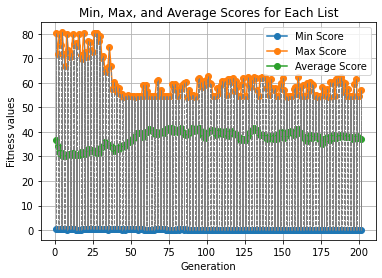

In [161]:
min_values = [min(lst) for lst in fitness]
max_values = [max(lst) for lst in fitness]
avg_values = [sum(lst) / len(lst) for lst in fitness]

# Create an array representing the list indices
list_indices = range(1, len(fitness)+1)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the min, max, and average values with lines connecting them
plt.plot(list_indices, min_values, label="Min Score", marker='o')
plt.plot(list_indices, max_values, label="Max Score", marker='o')
plt.plot(list_indices, avg_values, label="Average Score", marker='o')

# Connect min to max, max to average, and average to min with lines
for i in range(len(list_indices)):
    plt.plot([list_indices[i], list_indices[i]], [min_values[i], max_values[i]], color='gray', linestyle='--', linewidth=1)
    plt.plot([list_indices[i], list_indices[i]], [max_values[i], avg_values[i]], color='gray', linestyle='--', linewidth=1)
    plt.plot([list_indices[i], list_indices[i]], [avg_values[i], min_values[i]], color='gray', linestyle='--', linewidth=1)

# Set labels and title
plt.xlabel("Generation")
plt.ylabel("Fitness values")
plt.title("Min, Max, and Average Scores for Each List")

# Add legend
plt.legend()

# Show the plot
plt.grid()
plt.show()

In [153]:
fitness.size

200

In [56]:
from tqdm.notebook import tqdm_notebook
import pandas as pd

# parameters
generation_max = 350
pop_size = 200
dim = 2

experiments = 10
experiments_min_fitnesses = []
experiments_max_fitnesses = []
experiments_ave_fitnesses = []
experiments_stddev_fitnesses = []

i, s, c, m = 1,1,2,1
func = styblinski_tang

for _ in tqdm_notebook(range(experiments)):
    population, fitness =  ea_neg_impr_termination( dim=dim,
                                               generation_max=generation_max,
                                               fitness_function=func,
                                              # CHANGEEE FILE PATHHHH !!!!!!!!!!!!!
                                               bounds_per_dim=[-5.17, 5.17],
                                               pop_size=pop_size,
                                               initializer=i,
                                               selection_method=s,
                                               crossover=c,
                                               mutation=m)
    final_fitness = fitness[-1]
    final_fitness_min = min(final_fitness)
    final_fitness_max = max(final_fitness)
    final_fitness_ave = np.nanmeanmean(final_fitness)
    final_fitness_stddev = np.nanstdstd(final_fitness)

    experiments_min_fitnesses.append(final_fitness_min)
    experiments_max_fitnesses.append(final_fitness_max)
    experiments_ave_fitnesses.append(final_fitness_ave)
    experiments_stddev_fitnesses.append(final_fitness_stddev)


data = {
'min fitness': experiments_min_fitnesses,
'max fitness': experiments_max_fitnesses,
'ave fitness': experiments_ave_fitnesses,
'std_dev fitness': experiments_stddev_fitnesses
}

df = pd.DataFrame(data)
df.to_csv(f'C:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results/GA_{func.__name__}_{i}_{s}_{c}_{m}_neg_impr_termination.csv')

  0%|          | 0/10 [00:00<?, ?it/s]

In [60]:

import pandas as pd
from tqdm.notebook import tqdm_notebook


# parameters
generation_max = 350
pop_size = 100
dim = 2
# Define argument values
bounds_per_dim = [-5.15, 5.17]
initializations = [1, 2]
selections = [1, 2]
crossovers = [1, 2]
mutations = [1, 2]

# List of functions
functions = [rastrigin, rosenbrock, styblinski_tang]

# Create a directory to save CSV files
import os
output_dir = '/content/drive/MyDrive/MSc/Mizzou/CI project 1/results'
os.makedirs(output_dir, exist_ok=True)

g = 0
for func in tqdm_notebook(functions):
  print(func.__name__)

  for initialization in initializations:
    for selection in selections:
      for mutation in mutations:
        for crossover in crossovers:

          experiments = 10
          experiments_min_fitnesses = []
          experiments_max_fitnesses = []
          experiments_ave_fitnesses = []
          experiments_stddev_fitnesses = []

          # run 10 experiments for current operators
          for experiment in tqdm_notebook(range(experiments)):
            population, fitness = ea_neg_impr_termination(dim=dim,
                                                      generation_max=generation_max,
                                                      fitness_function=func,
                                                      bounds_per_dim=bounds_per_dim,
                                                      pop_size = pop_size,
                                                      initializer=initialization,
                                                      selection_method=selection,
                                                      crossover=crossover,
                                                      mutation=mutation)

            final_fitness = fitness[-1]
            final_fitness_min = min(final_fitness)
            final_fitness_max = max(final_fitness)
            final_fitness_ave = np.nanmean(final_fitness)
            final_fitness_stddev = np.nanstd(final_fitness)

            experiments_min_fitnesses.append(final_fitness_min)
            experiments_max_fitnesses.append(final_fitness_max)
            experiments_ave_fitnesses.append(final_fitness_ave)
            experiments_stddev_fitnesses.append(final_fitness_stddev)


          data = {
          'min fitness': experiments_min_fitnesses,
          'max fitness': experiments_max_fitnesses,
          'ave fitness': experiments_ave_fitnesses,
          'std_dev fitness': experiments_stddev_fitnesses
          }

          df = pd.DataFrame(data)

          # get function name
          func_name = func.__name__
          # Create a unique file name for each combination and function
          file_name = f'GA_{func_name}_{initialization}_{selection}_{crossover}_{mutation}_neg_impr_termination.csv'
          file_path = os.path.join(output_dir, file_name)

          # Save the Pandas DataFrame as a CSV file
          df.to_csv(file_path, index=False)
          g += 1
          print(f'Saved {g} CSV files in the "{output_dir}" directory.')

  0%|          | 0/3 [00:00<?, ?it/s]

rastrigin


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 1 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 2 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 3 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 4 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 5 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 6 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 7 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 8 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 9 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 10 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 11 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 12 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 13 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 14 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 15 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 16 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.
rosenbrock


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 17 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 18 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 19 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 20 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 21 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 22 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 23 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 24 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 25 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 26 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 27 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 28 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 29 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 30 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 31 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 32 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.
styblinski_tang


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 33 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 34 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 35 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 36 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 37 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 38 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 39 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 40 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 41 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 42 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 43 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 44 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 45 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 46 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 47 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


  0%|          | 0/10 [00:00<?, ?it/s]

Saved 48 CSV files in the "/content/drive/MyDrive/MSc/Mizzou/CI project 1/results" directory.


# Extract data from results

### Check which csv files have corrupt values

In [63]:
import os
import pandas as pd
import numpy as np

# Function to check for infinite, NaN, or blank values in a DataFrame
def check_dataframe(df):
    has_infinite = df.select_dtypes(include=[np.number]).applymap(np.isinf).any().any()
    has_nan = df.isnull().values.any()
    has_blank = (df.applymap(lambda x: isinstance(x, str) and x.isspace())).any().any()
    
    return has_infinite, has_nan, has_blank

# Directory where CSV files are located
csv_directory = 'c:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results'

# Iterate through CSV files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        file_path = os.path.join(csv_directory, filename)
        
        try:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path)

            
            # Check for infinite, NaN, or blank values in the DataFrame
            has_infinite, has_nan, has_blank = check_dataframe(df)
            
            # Print the results
            if has_infinite or has_nan or has_blank:
                print(f"File: {filename}")
                print(f"Has Infinite Values: {has_infinite}")
                print(f"Has NaN Values: {has_nan}")
                print(f"Has Blank (Empty) Values: {has_blank}")
                print("-" * 40)
        
        except Exception as e:
            print(f"Error reading {filename}: {e}")



File: GA_rastrigin_1_1_2_1_neg_impr_termination.csv
Has Infinite Values: True
Has NaN Values: False
Has Blank (Empty) Values: False
----------------------------------------
File: GA_rastrigin_2_1_2_1_neg_impr_termination.csv
Has Infinite Values: True
Has NaN Values: False
Has Blank (Empty) Values: False
----------------------------------------
File: GA_rosenbrock_1_1_1_1_neg_impr_termination.csv
Has Infinite Values: False
Has NaN Values: True
Has Blank (Empty) Values: False
----------------------------------------
File: GA_rosenbrock_1_1_1_2_neg_impr_termination.csv
Has Infinite Values: False
Has NaN Values: True
Has Blank (Empty) Values: False
----------------------------------------
File: GA_rosenbrock_2_1_1_2_neg_impr_termination.csv
Has Infinite Values: False
Has NaN Values: True
Has Blank (Empty) Values: False
----------------------------------------
File: GA_styblinski_tang_1_1_1_1_neg_impr_termination.csv
Has Infinite Values: False
Has NaN Values: True
Has Blank (Empty) Values: 

In [95]:
# Initialize the custom dataframe
custom_dataframe = pd.DataFrame(index=range(32), columns=["GA", "rastrigin", "rosenbrock", "styblinski-tang"])
# Specify the directory containing your CSV files
directory = 'C:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results'

### Stats related to minimum fitness for all test functions

In [96]:
# Specify the directory containing your CSV files
directory = 'C:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results'

# Initialize an empty list to store the calculated statistics
rastrigin_stats = []


# Specify the file prefix you want to filter
file_prefix = 'GA_rastrigin'

# List all files in the directory
file_list = os.listdir(directory)

# Iterate through the files and read only those with the specified prefix
for file_name in file_list:
    if file_name.startswith(file_prefix) and file_name.endswith('.csv'):
        file_path = os.path.join(directory, file_name)
        
        # Read the CSV file and select the "min fitness" column
        df = pd.read_csv(file_path, usecols=["min fitness"])
        
        # Calculate the average and standard deviation of the "min fitness" column
        avg_min_fitness = round(df["min fitness"].mean(skipna=True), 5)
        std_min_fitness = round(df["min fitness"].std(skipna=True), 5)
        # Format the statistics to 5 decimal places
        np.round(avg_min_fitness, 5), np.round(std_min_fitness, 5)
        
        # Append the statistics to the rastrigin_stats list
        rastrigin_stats.append((avg_min_fitness, std_min_fitness))
        
# Populate the "rastrigin" column in the custom dataframe with the computed statistics
if rastrigin_stats:
    custom_dataframe["rastrigin"] = rastrigin_stats
    
# Display the custom dataframe
custom_dataframe

,GA,rastrigin,rosenbrock,styblinski-tang
0,NaN,"(4.42761, 8.93455)",NaN,NaN
1,NaN,"(0.17316, 0.4293)",NaN,NaN
2,NaN,"(28.86975, 12.55303)",NaN,NaN
3,NaN,"(6.7603, 4.72093)",NaN,NaN
4,NaN,"(5.18185, 8.55893)",NaN,NaN
5,NaN,"(0.6939, 0.43439)",NaN,NaN
6,NaN,"(23.91512, 6.98181)",NaN,NaN
7,NaN,"(13.12021, 6.03041)",NaN,NaN
8,NaN,"(0.19917, 0.41989)",NaN,NaN
9,NaN,"(0.0, 0.0)",NaN,NaN


In [97]:

# Initialize an empty list to store the calculated statistics
rosenbrock_stats = []


# Specify the file prefix you want to filter
file_prefix = 'GA_rosenbrock'

# List all files in the directory
file_list = os.listdir(directory)

# Iterate through the files and read only those with the specified prefix
for file_name in file_list:
    if file_name.startswith(file_prefix) and file_name.endswith('.csv'):
        file_path = os.path.join(directory, file_name)
        
        # Read the CSV file and select the "min fitness" column
        df = pd.read_csv(file_path, usecols=["min fitness"])
        
        # Calculate the average and standard deviation of the "min fitness" column
        avg_min_fitness = round(df["min fitness"].mean(skipna=True), 5)
        std_min_fitness = round(df["min fitness"].std(skipna=True), 5)
        
        # Append the statistics to the rastrigin_stats list
        rosenbrock_stats.append((avg_min_fitness, std_min_fitness))
        
# Populate the "rastrigin" column in the custom dataframe with the computed statistics
if rosenbrock_stats:
    custom_dataframe["rosenbrock"] = rosenbrock_stats
    
# Display the custom dataframe
custom_dataframe

,GA,rastrigin,rosenbrock,styblinski-tang
0,NaN,"(4.42761, 8.93455)","(2.16342, 3.62717)",NaN
1,NaN,"(0.17316, 0.4293)","(0.19468, 0.19579)",NaN
2,NaN,"(28.86975, 12.55303)","(46.23346, 117.12398)",NaN
3,NaN,"(6.7603, 4.72093)","(4.25534, 5.14191)",NaN
4,NaN,"(5.18185, 8.55893)","(0.6947, 0.28872)",NaN
5,NaN,"(0.6939, 0.43439)","(0.06524, 0.09436)",NaN
6,NaN,"(23.91512, 6.98181)","(7.75281, 6.3496)",NaN
7,NaN,"(13.12021, 6.03041)","(0.46151, 0.44526)",NaN
8,NaN,"(0.19917, 0.41989)","(0.00018, 0.00014)",NaN
9,NaN,"(0.0, 0.0)","(5e-05, 3e-05)",NaN


In [98]:

# Initialize an empty list to store the calculated statistics
styblinski_tang_stats = []


# Specify the file prefix you want to filter
file_prefix = 'GA_styblinski_tang'

# List all files in the directory
file_list = os.listdir(directory)

# Iterate through the files and read only those with the specified prefix
for file_name in file_list:
    if file_name.startswith(file_prefix) and file_name.endswith('.csv'):
        file_path = os.path.join(directory, file_name)
        
        # Read the CSV file and select the "min fitness" column
        df = pd.read_csv(file_path, usecols=["min fitness"])
        
        # Calculate the average and standard deviation of the "min fitness" column
        avg_min_fitness = round(df["min fitness"].mean(skipna=True), 5)
        std_min_fitness = round(df["min fitness"].std(skipna=True), 5)
        
        # Append the statistics to the rastrigin_stats list
        styblinski_tang_stats.append((avg_min_fitness, std_min_fitness))
        
# Populate the "rastrigin" column in the custom dataframe with the computed statistics
if styblinski_tang_stats:
    custom_dataframe["styblinski-tang"] = styblinski_tang_stats
    
# Display the custom dataframe
custom_dataframe

,GA,rastrigin,rosenbrock,styblinski-tang
0,NaN,"(4.42761, 8.93455)","(2.16342, 3.62717)","(-46.80871, 31.01501)"
1,NaN,"(0.17316, 0.4293)","(0.19468, 0.19579)","(-64.12463, 10.70633)"
2,NaN,"(28.86975, 12.55303)","(46.23346, 117.12398)","(-49.60047, 44.3715)"
3,NaN,"(6.7603, 4.72093)","(4.25534, 5.14191)","(-54.70726, 12.64007)"
4,NaN,"(5.18185, 8.55893)","(0.6947, 0.28872)","(-38.02719, 18.75462)"
5,NaN,"(0.6939, 0.43439)","(0.06524, 0.09436)","(-73.47272, 6.58774)"
6,NaN,"(23.91512, 6.98181)","(7.75281, 6.3496)","(-48.85729, 12.14624)"
7,NaN,"(13.12021, 6.03041)","(0.46151, 0.44526)","(-68.48704, 11.25857)"
8,NaN,"(0.19917, 0.41989)","(0.00018, 0.00014)","(-78.31515, 0.01752)"
9,NaN,"(0.0, 0.0)","(5e-05, 3e-05)","(-78.32783, 0.00227)"


In [106]:
custom_dataframe['GA'] = np.arange(1,len(custom_dataframe.rastrigin)+1)
custom_dataframe

,GA,rastrigin,rosenbrock,styblinski-tang
0,1,"(4.42761, 8.93455)","(2.16342, 3.62717)","(-46.80871, 31.01501)"
1,2,"(0.17316, 0.4293)","(0.19468, 0.19579)","(-64.12463, 10.70633)"
2,3,"(28.86975, 12.55303)","(46.23346, 117.12398)","(-49.60047, 44.3715)"
3,4,"(6.7603, 4.72093)","(4.25534, 5.14191)","(-54.70726, 12.64007)"
4,5,"(5.18185, 8.55893)","(0.6947, 0.28872)","(-38.02719, 18.75462)"
5,6,"(0.6939, 0.43439)","(0.06524, 0.09436)","(-73.47272, 6.58774)"
6,7,"(23.91512, 6.98181)","(7.75281, 6.3496)","(-48.85729, 12.14624)"
7,8,"(13.12021, 6.03041)","(0.46151, 0.44526)","(-68.48704, 11.25857)"
8,9,"(0.19917, 0.41989)","(0.00018, 0.00014)","(-78.31515, 0.01752)"
9,10,"(0.0, 0.0)","(5e-05, 3e-05)","(-78.32783, 0.00227)"


In [108]:

output_file = 'min_fitness_stats.csv'
custom_dataframe.to_csv(output_file, index=False)


### Comparison using a single fitness function: rosenbrock

In [116]:
import pandas as pd
import glob

# Initialize an empty dataframe to store the results
result_df = pd.DataFrame(columns=["GA", "min fitness", "max fitness", "avg fitness", "std dev"])

# Find all CSV files with the pattern "GA_rosenbrock*.csv"
file_pattern = "GA_rosenbrock*.csv"
csv_files = glob.glob(f'{directory}/{file_pattern}')

# Initialize the GA counter
ga_counter = 1

# Iterate through each CSV file
for csv_file in csv_files:
    # Read the CSV file into a dataframe
    df = pd.read_csv(csv_file)

    # Extract the last row and truncate values to 5 decimal places
    last_row = df.iloc[-1].round(5).apply(lambda x: f'{x:.5e}' if isinstance(x, (int, float)) else x)

    # Create a dictionary for the row data
    row_data = {
        "GA": ga_counter,
        "min fitness": last_row["min fitness"],
        "max fitness": last_row["max fitness"],
        "avg fitness": last_row["ave fitness"],
        "std dev": last_row["std_dev fitness"]
    }

    # Append the row data to the result dataframe
    result_df = result_df.append(row_data, ignore_index=True)

    # Increment the GA counter
    ga_counter += 1

result_df
# Save the result dataframe to a CSV file
result_df.to_csv("result.csv", index=False)


C:\Users\kople\AppData\Local\Temp\ipykernel_18132\1552291983.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(row_data, ignore_index=True)
C:\Users\kople\AppData\Local\Temp\ipykernel_18132\1552291983.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(row_data, ignore_index=True)
C:\Users\kople\AppData\Local\Temp\ipykernel_18132\1552291983.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(row_data, ignore_index=True)
C:\Users\kople\AppData\Local\Temp\ipykernel_18132\1552291983.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = re

# Plots

In [81]:
population, fitness =  ea_max_termination( dim=1000,
                                           generation_max=200,
                                           fitness_function=rastrigin,
                                           bounds_per_dim=[-5.17, 5.17],
                                           pop_size=200,
                                           initializer=2,
                                           selection_method=2,
                                           crossover=1,
                                           mutation=1
                                           )

  0%|          | 0/199 [00:00<?, ?it/s]

In [165]:
print(len(fitness))
print(len(fitness[0]), len(fitness[1]))

200
200 400


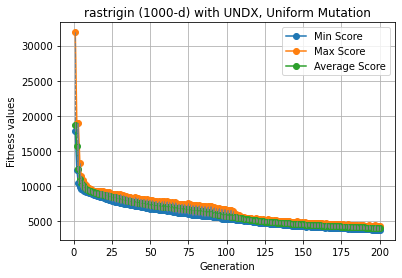

In [82]:
min_values = [min(lst) for lst in fitness]
max_values = [max(lst) for lst in fitness]
avg_values = [sum(lst) / len(lst) for lst in fitness]

# Create an array representing the list indices
list_indices = range(1, len(fitness)+1)

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the min, max, and average values with lines connecting them
plt.plot(list_indices, min_values, label="Min Score", marker='o')
plt.plot(list_indices, max_values, label="Max Score", marker='o')
plt.plot(list_indices, avg_values, label="Average Score", marker='o')

# Connect min to max, max to average, and average to min with lines
for i in range(len(list_indices)):
    plt.plot([list_indices[i], list_indices[i]], [min_values[i], max_values[i]], color='grey', linestyle='--', linewidth=1)
    plt.plot([list_indices[i], list_indices[i]], [max_values[i], avg_values[i]], color='grey', linestyle='--', linewidth=1)
    plt.plot([list_indices[i], list_indices[i]], [avg_values[i], min_values[i]], color='grey', linestyle='--', linewidth=1)

# Set labels and title
plt.xlabel("Generation")
plt.ylabel("Fitness values")
plt.title("rastrigin (1000-d) with UNDX, Uniform Mutation")

# Add legend
plt.legend()

# Show the plot
plt.grid()
plt.show()

# Contour plots

## Extract final population

In [23]:
func = rosenbrock

population, fitness =  ea_max_termination( dim=2,
                                           generation_max=200,
                                           fitness_function=func,
                                           bounds_per_dim=[-5.17, 5.17],
                                           pop_size=200,
                                           initializer=2,
                                           selection_method=2,
                                           crossover=1,
                                           mutation=1
                                           )


  0%|          | 0/199 [00:00<?, ?it/s]

In [25]:
population[-1][:5]

[array([1.00482, 1.01334]),
 array([1.00536, 1.01753]),
 array([1.00734, 1.01893]),
 array([1.00476, 0.99922]),
 array([0.99515, 1.00116])]

In [24]:
directory = "C:/Users/kople/Documents/Personal Git repos/mizzou_ea_project1/results/final_populations"

# Save the array with Pickle
with open(f'{directory}/{func.__name__}-2211.pkl', 'wb') as f:
    pickle.dump(population, f)


